Code for project 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

$\mathcal{IRENE'S \quad BLOCKS}$

Plot of the variables: High, Low, Close

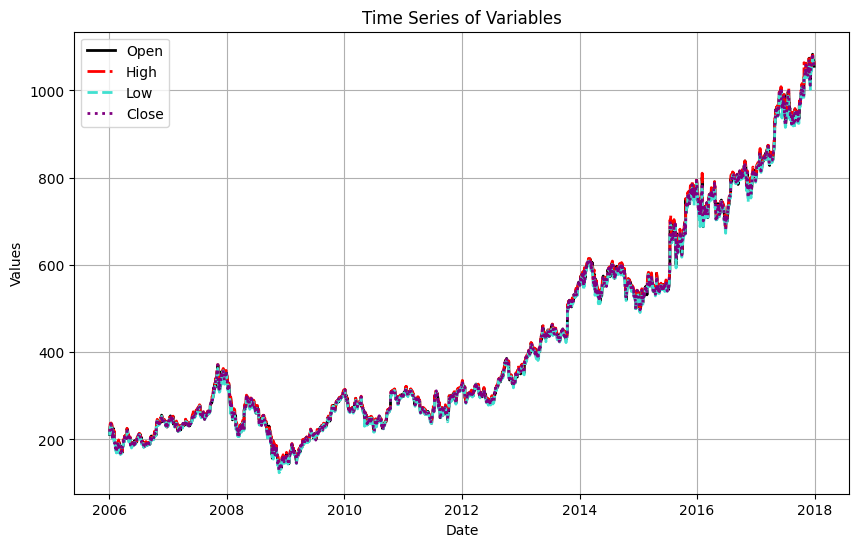

In [2]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date']) 
data.set_index('Date', inplace=True)
Open=data['Open']
High=data['High']
Low=data['Low']
Close=data['Close']
Volume=data['Volume']
plt.figure(figsize=(10, 6))
plt.plot(data.index, Open, label='Open', linewidth=2, linestyle='-', color='black' )
plt.plot(data.index, High, label='High', linewidth=2, linestyle='-.', color='red' )
plt.plot(data.index, Low, label='Low', linewidth=2, linestyle='--', color='turquoise' )
plt.plot(data.index, Close, label='Close', linewidth=2,linestyle=':', color='purple' )
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Variables')
plt.legend()
plt.grid(True)
plt.show()




Plot mean and SD envelopes to see better

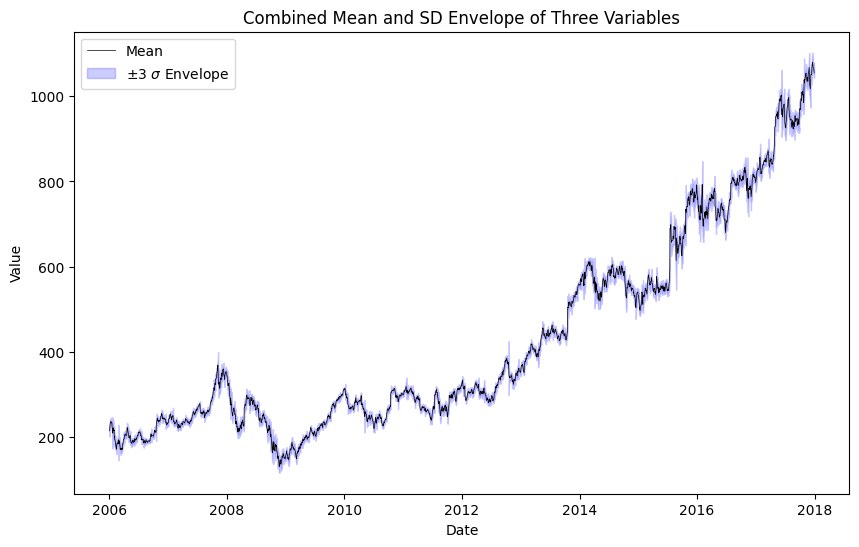

In [3]:
mean_all = data.iloc[:, [0,1, 2, 3]].mean(axis=1)
std_dev_all = data.iloc[:, [0,1, 2, 3]].std(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(data.index, mean_all, label='Mean', color='black', linewidth=0.5)
plt.fill_between(
    data.index,
    mean_all - 3*std_dev_all,  
    mean_all + 3*std_dev_all,  
    color='blue',
    alpha=0.2,  # Adjust transparency
    label='±3 $\sigma$ Envelope'
)

# Labeling the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Combined Mean and SD Envelope of Three Variables')
plt.legend()
plt.show()


Plot of the variable Volume

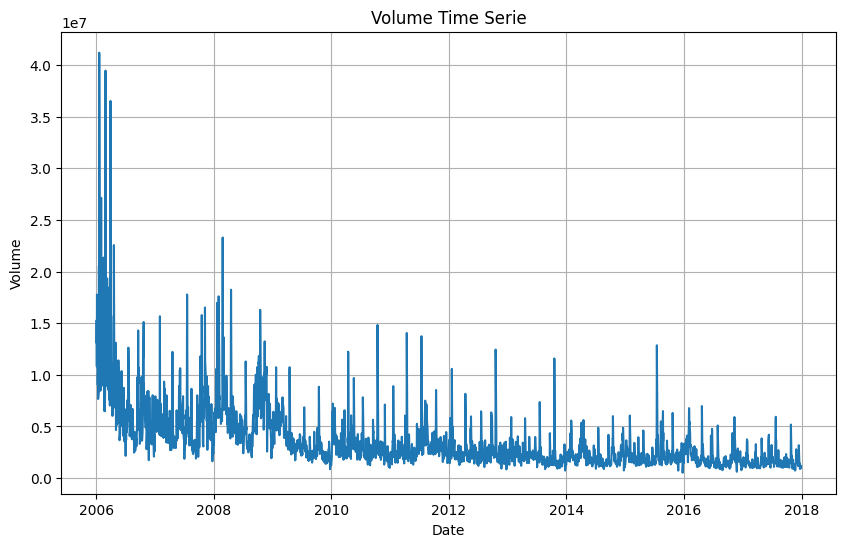

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, Volume, label="Volume")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume Time Serie')
plt.grid(True)
plt.show()

Seasonal Trent decomposition

/tmp/ipykernel_1891/1710637761.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data["Open"] = data["Open"].fillna(method='ffill')


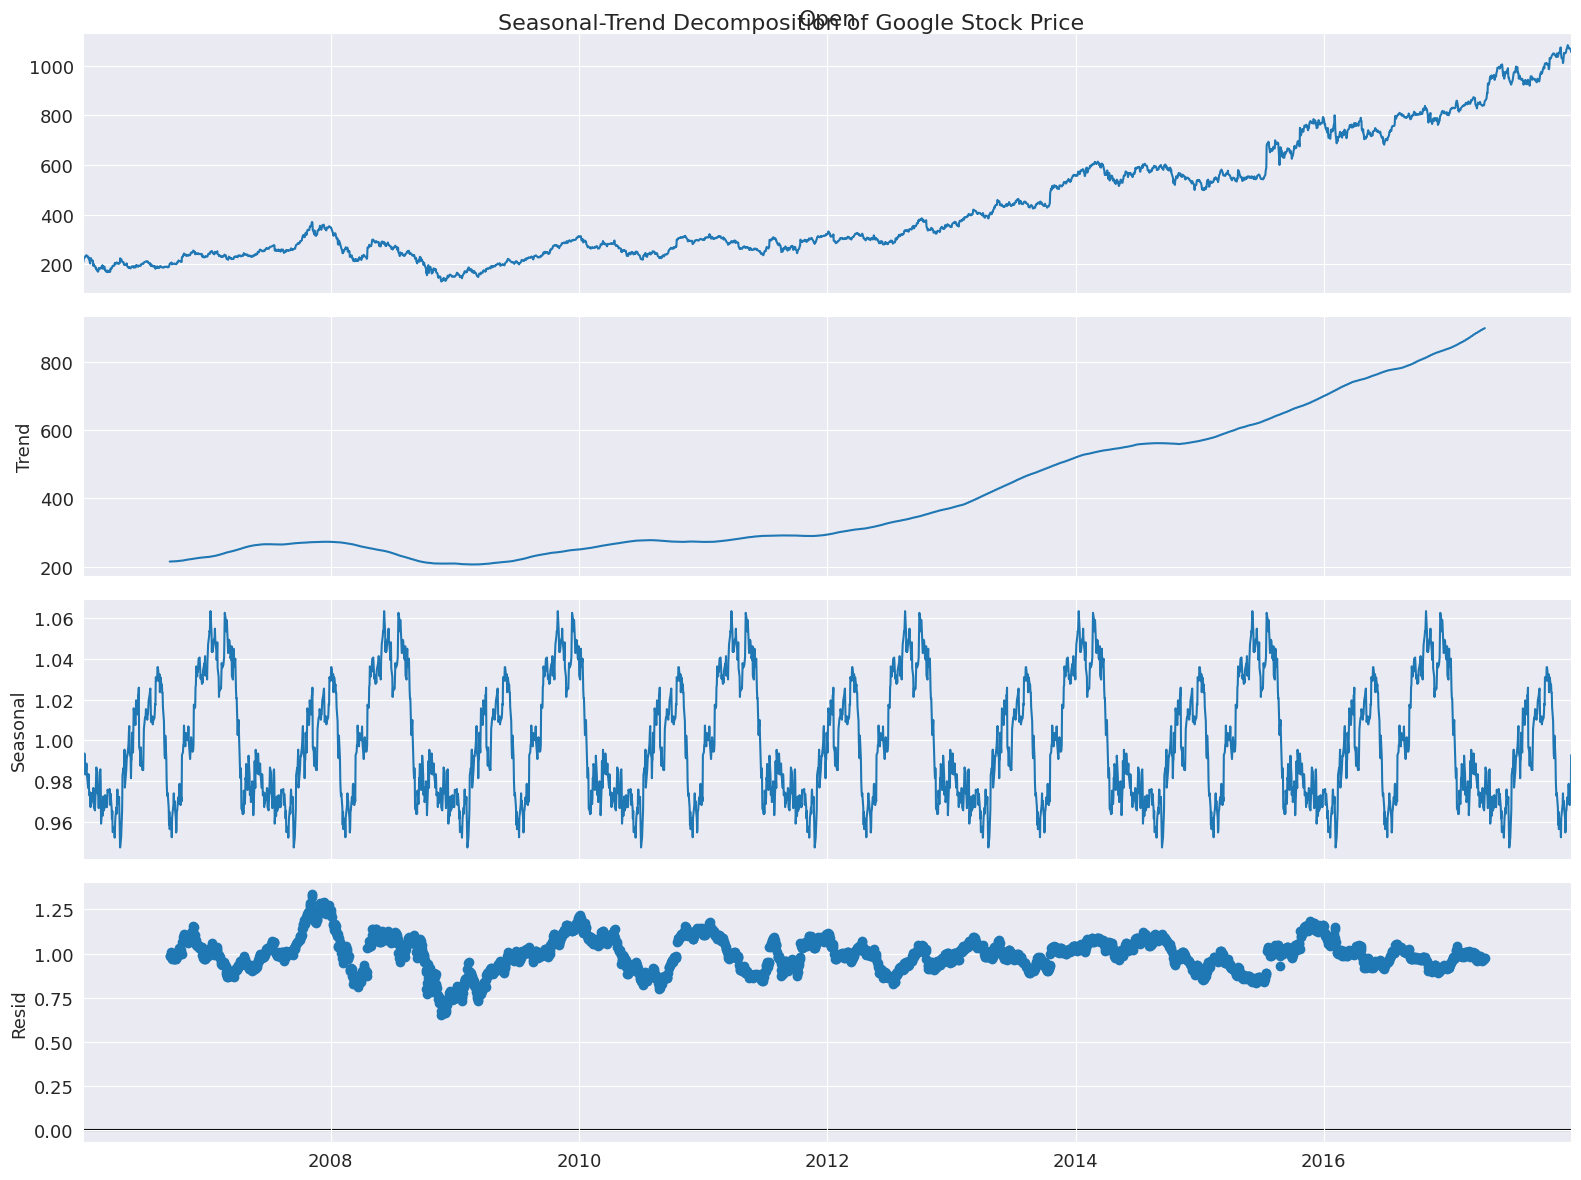

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the frequency and fill missing values
data["Open"] = data["Open"].fillna(method='ffill')
data["Open"].index = pd.to_datetime(data.index)
data["Open"] = data["Open"].asfreq('B')

# Perform the decomposition with weekly seasonality
result = seasonal_decompose(data["Open"], model='multiplicative', period=365)
result.plot()
plt.suptitle("Seasonal-Trend Decomposition of Google Stock Price", fontsize=16)
plt.show()


Anton's blocks: added alternate visualisation of stock price over time and volume traded per price graph

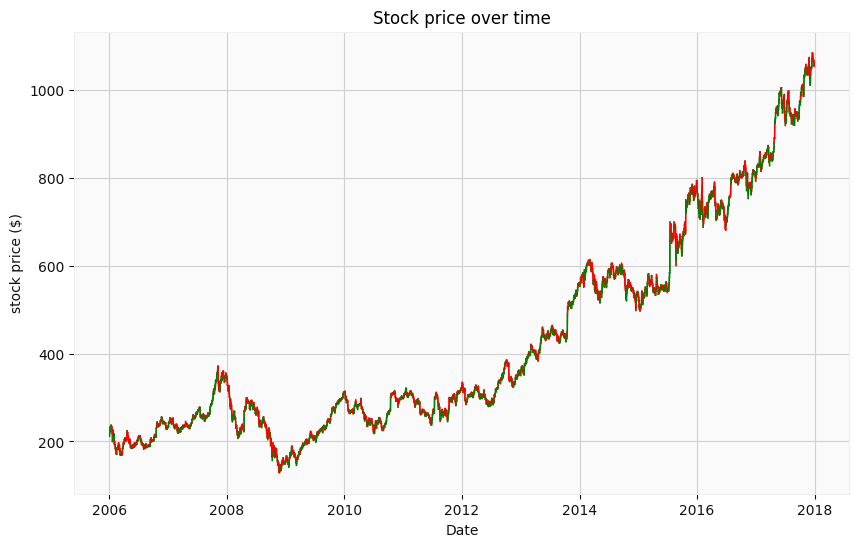

In [ ]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date']) 
data.set_index('Date', inplace=True)

Open = data['Open']
Close=data['Close']

Volume=data['Volume']

plt.figure(figsize=(10, 6))

# Loop through the data and plot in different colors based on the condition
for i in range(1, len(data)):

    date_current = data.index[i-1:i+1]

    # Choose color based on condition
    if Close.iloc[i] > Open.iloc[i]:
        color = 'green'
    else:
        color = 'red'
    
    # Plot the segments with the chosen color
    plt.plot(date_current, [Open.iloc[i-1], Open.iloc[i]], color=color, linestyle='-', linewidth=1)
    plt.plot(date_current, [Close.iloc[i-1], Close.iloc[i]], color=color, linestyle='-', linewidth=1)

plt.xlabel('Date')
plt.ylabel('stock price ($)')
plt.title('Stock price over time')
plt.grid(True)
plt.show()

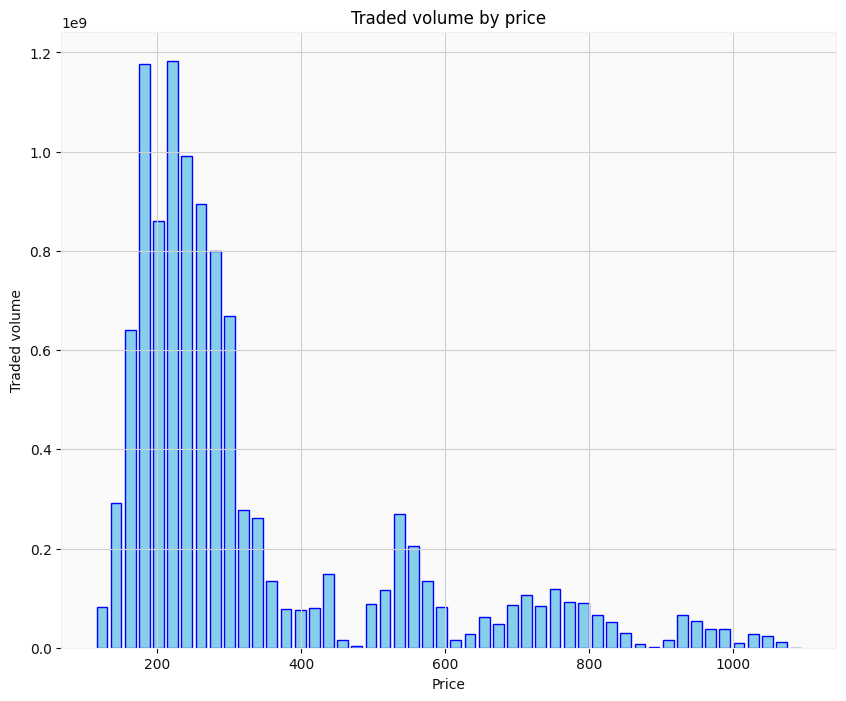

In [ ]:
import numpy as np

num_bins = 50 # Number of bins

# Define price bins based on high and low price
price_min = data['Low'].min()
price_max = data['High'].max()
bins = np.linspace(price_min, price_max, num_bins)

# Calculate the midpoints of the bins for plotting

# Calculate the volume in each price bin
volume_by_price = np.zeros(len(bins))

for i in range(len(bins)-1):
    mask = (Close >= bins[i]) & (Close < bins[i + 1])
    volume_by_price[i] = Volume[mask].sum()

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Create a horizontal bar chart for volume by price
ax.bar(bins, volume_by_price, align='center', color='skyblue', edgecolor='blue', width=15)
ax.set_xlabel('Price')
ax.set_ylabel('Traded volume')
ax.set_title('Traded volume by price')

plt.show()